RatS-Day2-2020-11-27_10-22-29


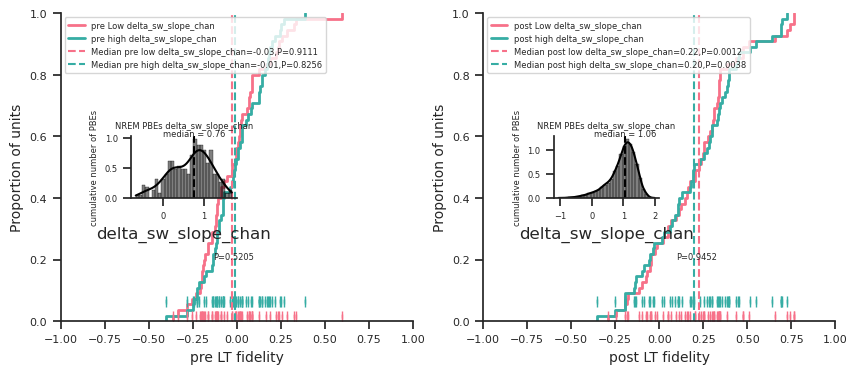

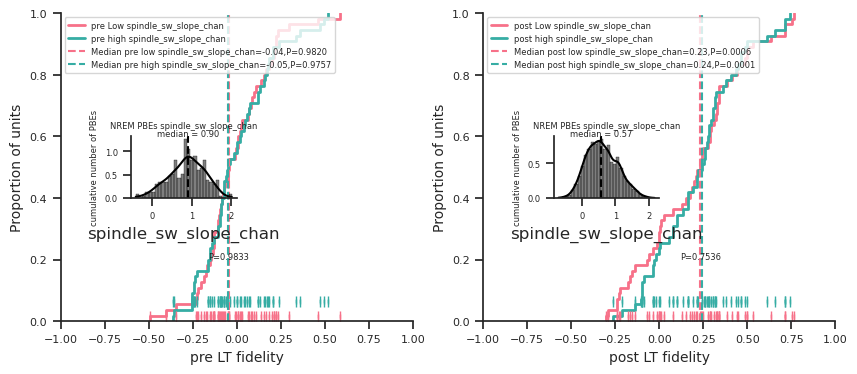

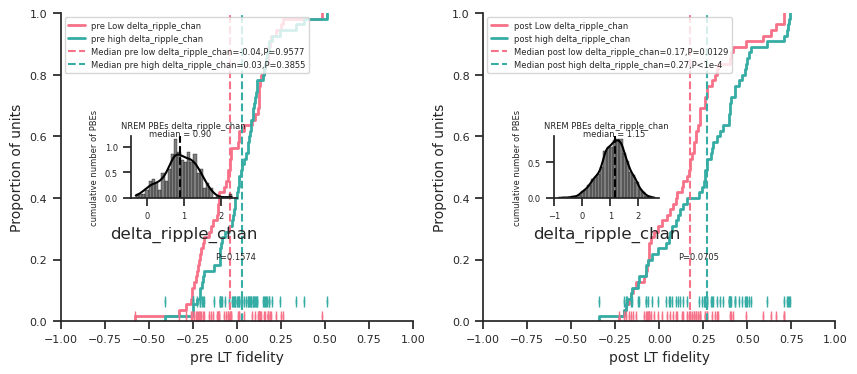

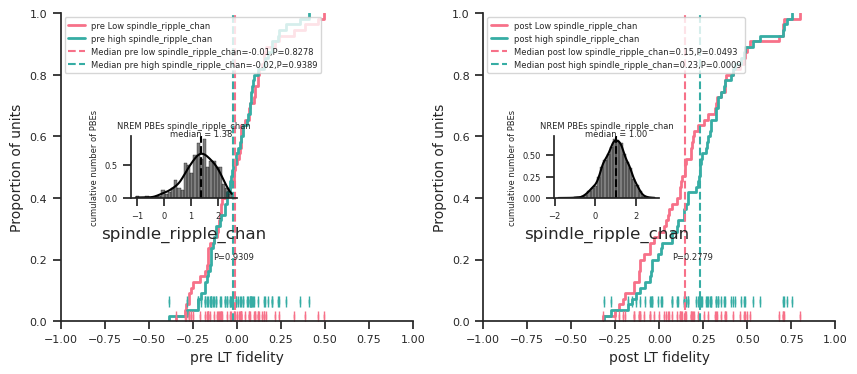

In [15]:
import os
import scipy.io
from scipy.stats import ranksums
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_place_field_fidelity_of_learned_tuning, calculate_learned_tuning_matched_participation

normalize_to_max = lambda x:(x/np.nanmax(x))


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
state_detection_dir =  r'/home/kouroshmaboudi/Documents/NCMLproject/StateDetectionResults/'

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (12, 13)]
# included_session_IDX = [x for x in range(9,17) if x not in (12,13)] # Grosmark sessions
included_session_IDX = [7]

# included_session_IDX = [14, 15, 16]

sessions = [sessions[i] for i in included_session_IDX]

for sesison_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[sesison_idx]


    session_state_detection_results_path = os.path.join(state_detection_dir, session_name)

    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
   


     #----------------------------------------------------------------------------------------------
    # Load spike data
    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]


    # Load unit stability information

    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]



    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]


    if session_number in [6,7]:
        num_units = spatial_tuning_smoothed.shape[0] # for RatN and RatS
    else:
        num_units = spatial_tuning_smoothed[0].shape[0]
        
    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}

        
        for direction in running_directions:
            try:
                if session_number in [6,7]:
                    unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]


            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['shank_id']    += 1
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
        else: # Grosmark, Hiro, and all other sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]



        spikes.append(unit_spikes) 



    # place fields by pooling spikes across both running directions
    place_fields_uni = []
    for unit in range(num_units):
        place_fields_uni.append(spikes[unit]['place_fields']['uni'])
    place_fields_uni = np.array(place_fields_uni)

    place_fields_uni[place_fields_uni == 0] = 1e-4
    active_units = np.where(np.nanmax(place_fields_uni, axis=1) > 1)[0]



    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)



    #-------------------------------------------------------------------------------------------
    # Loading the population burst evenst with all their corresponding measured lfp features

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
       

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  
  
            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]


    # # Adding SWA that Bapun calculated - only for RatU
    # filename = f'{session_name}.SWA_activity_for_Kourosh.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # swa_arr = np.load(file_path, allow_pickle=True).item()

    # swa = swa_arr['swa']
    # swa_t_start = swa_arr['t_start']
    # # swa_window_length = swa_arr['window']
    # # swa_windows_overlap = swa_arr['overlap']
    # swa_time_pnts = np.arange(swa_t_start, swa.shape[0]+.1, 1)
    
    # PBEs['swa_bapun'] = np.interp(PBEs['peakT'], swa_time_pnts, swa)


    # # Adding delta and spindle that I calculated using the multitaper method using a channel that showed the highest ripple power
    # filename = f'{session_name}.delta_spindle_multitaper.mat'
    # file_path = os.path.join(session_dataset_path, filename)

    # mat_file = scipy.io.loadmat(file_path)
    # tPnts = mat_file['t'].flatten()
    # spindle_power_multitaper = mat_file['spindle_power'].flatten()
    # delta_power_multitaper = mat_file['delta_power'].flatten()


    # PBEs['delta_power_multitaper'] = np.interp(PBEs['peakT'], tPnts, delta_power_multitaper)
    # PBEs['spindle_power_multitaper'] = np.interp(PBEs['peakT'], tPnts, spindle_power_multitaper)


    # Adding delta and spindle that I calculated using spectrogram and without whitening

    ## using the channel that showed the highest bipolarity in slow wave slope - using MATLAB Buzcode
    filename = f'{session_name}.delta_spindle_spectrogram_tukey_prior_zscoring_best_sw_slope_channel.mat'
    file_path = os.path.join(session_state_detection_results_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    tPnts = mat_file['t'].flatten()
    delta_power = mat_file['delta_power'].flatten()
    spindle_power = mat_file['spindle_power'].flatten()


    PBEs['delta_sw_slope_chan'] = np.interp(PBEs['peakT'], tPnts, delta_power)
    PBEs['spindle_sw_slope_chan'] = np.interp(PBEs['peakT'], tPnts, spindle_power)


    ## using the channel with highest ripple power
    filename = f'{session_name}.delta_spindle_spectrogram_tukey_prior_zscoring_best_ripple_channel.mat'
    file_path = os.path.join(session_state_detection_results_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    tPnts = mat_file['t'].flatten()
    delta_power = mat_file['delta_power'].flatten()
    spindle_power = mat_file['spindle_power'].flatten()

    PBEs['delta_ripple_chan'] = np.interp(PBEs['peakT'], tPnts, delta_power)
    PBEs['spindle_ripple_chan'] = np.interp(PBEs['peakT'], tPnts, spindle_power)


    #------------------------------------------------------------------------------------------------------
    # Learned tunings calculated based on NREM PBEs with values of certain lfp features like ripple power, slow wave amplitude, and spindle power within a low or high range (along the median)

    num_PBEs = PBEs.shape[0]
    brain_state_first_letter = np.empty((num_PBEs,), dtype='str')

    epoch_names = ['pre', 'post']
    # lfp_features = ['swa_bapun']
    # lfp_features = ['SWA', 'spindleP', 'peakRippleA', 'peakMUA', 'nFiringUnits', 'duration']
    lfp_features = ['delta_sw_slope_chan', 'spindle_sw_slope_chan', 'delta_ripple_chan', 'spindle_ripple_chan'] # 'delta_power_multitaper', 'spindle_power_multitaper', 


    lfp_feature_threshold = {epoch:{lfp_feature:None for lfp_feature in lfp_features} for epoch in epoch_names} 
    epoch_PBEs_lfp_feature_value = {epoch:{lfp_feature:None for lfp_feature in lfp_features} for epoch in epoch_names} # The distribution of a specific lfp feature within each epoch

    PBEs_indices_low_vs_high_lfp_feature = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in lfp_features} for epoch in epoch_names}
    num_PBEs_low_vs_high_lfp_feature = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in lfp_features} for epoch in epoch_names}
    learned_tunings_low_vs_high_lfp_feature_matched_particpation = {epoch: {lfp_feature: {'low':None, 'high': None} for lfp_feature in lfp_features} for epoch in epoch_names}



    time_bin_duration = 0.02
    num_PF_shuffles = 10000

    for epoch in epoch_names:
        if epoch == 'pre':
            epoch_idx = 0
            epoch_duration = epochs[0,1] - epochs[0,0]
        elif epoch == 'post':
            epoch_idx = 2
            epoch_duration = 4*60*60 # limiting to the first 4 hours of post sleep

        if_inside_epoch = PBEs['peakT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)
        if_PBEs_is_NREM_and_within_epoch = if_inside_epoch & (PBEs['brainState'] == 'NREM') # within the epoch and only includes NREM PBEs

        for lfp_feature in lfp_features:
            
            # calculate median value of each lfp feature across all NREM PBEs ocurring within the epoch
            epoch_PBEs_lfp_feature_value[epoch][lfp_feature] = PBEs[lfp_feature][if_PBEs_is_NREM_and_within_epoch]

            lfp_feature_threshold[epoch][lfp_feature] = np.nanmedian(epoch_PBEs_lfp_feature_value[epoch][lfp_feature])

            # Indices of PBEs ocurring during each epoch and during high or low values of lfp-feature
            low_indices = np.where(if_PBEs_is_NREM_and_within_epoch & (PBEs[lfp_feature] < lfp_feature_threshold[epoch][lfp_feature]))[0]
            high_indices = np.where(if_PBEs_is_NREM_and_within_epoch & (PBEs[lfp_feature] >= lfp_feature_threshold[epoch][lfp_feature]))[0]

            PBEs_indices_low_vs_high_lfp_feature[epoch][lfp_feature]['low'] = low_indices
            num_PBEs_low_vs_high_lfp_feature[epoch][lfp_feature]['low'] = low_indices.shape[0]

            PBEs_indices_low_vs_high_lfp_feature[epoch][lfp_feature]['high'] = high_indices
            num_PBEs_low_vs_high_lfp_feature[epoch][lfp_feature]['high'] = high_indices.shape[0]



    # calculate learned tunings within each epoch *using all offline PBEs*, regardless of their corresponding brain state   
    learned_tunings_low_vs_high_lfp_feature_matched_particpation = calculate_learned_tuning_matched_participation(PBEs, spikes, PBEs_indices_low_vs_high_lfp_feature, L_ratios, time_bin_duration)


    filename = f'{session_name}.learned_tunings_low_versus_high_lfp_feature_matched_particpation_NREM_delta_spindle_spectrogram.npy'
    file_path = os.path.join(session_dataset_path, filename)
    np.save(file_path, learned_tunings_low_vs_high_lfp_feature_matched_particpation)




    # Plot the distributions of LT fidelities for LTs calculated separately based on low or high level of lfp features values

    for current_lfp_feature in lfp_features:

        # Plot the distributions of learned tunings for low and high SWA within each sleep epoch
        colors = sns.color_palette("husl", 2) # Set color palette
        sns.set_style('whitegrid') # Set style and context
        sns.set_context('paper')

        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)

        fig, axes = plt.subplots(1,2, figsize = (10, 4))

        for i, epoch in enumerate(epoch_names):
            
            learned_tunings_pearson_corr_NREM_low_lfp_feature_value, _, median_LT_PF_pearson_corr_NREM_low_lfp_feature_value = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_low_vs_high_lfp_feature_matched_particpation[epoch][current_lfp_feature]['low'][active_units], place_fields_uni[active_units], num_PF_shuffles)
            learned_tunings_pearson_corr_NREM_high_lfp_feature_value, _, median_LT_PF_pearson_corr_NREM_high_lfp_feature_value = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_low_vs_high_lfp_feature_matched_particpation[epoch][current_lfp_feature]['high'][active_units], place_fields_uni[active_units], num_PF_shuffles)

            # Plot the distributions using ECDFs with overlaid ticks
            sns.ecdfplot(learned_tunings_pearson_corr_NREM_low_lfp_feature_value, ax = axes[i], label=f'{epoch} Low {current_lfp_feature}', color=colors[0], linewidth = 2)
            sns.ecdfplot(learned_tunings_pearson_corr_NREM_high_lfp_feature_value, ax = axes[i], label=f'{epoch} high {current_lfp_feature}', color=colors[1], linewidth = 2)

            axes[i].set_xlim([-1,1])
            axes[i].set_xlabel(f'{epoch} LT fidelity', fontsize=10)
            axes[i].set_ylabel('Proportion of units', fontsize=10)
            axes[i].tick_params(labelsize=8)
            axes[i].legend(fontsize=8)


            # Add ticks to the x-axis
            y_min, y_max = axes[i].get_ylim()
            for x in learned_tunings_pearson_corr_NREM_low_lfp_feature_value:
                axes[i].plot([x, x], [y_min+0.01, y_min + 0.02], '|-', color=colors[0], linewidth=0.25)
            for x in learned_tunings_pearson_corr_NREM_high_lfp_feature_value:
                axes[i].plot([x, x], [y_min+0.06, y_min + 0.07], '|-', color=colors[1], linewidth=0.25)
            

            # Calculate and display medians
            median_corr_low_lfp_feature = median_LT_PF_pearson_corr_NREM_low_lfp_feature_value['data']
            median_corr_low_lfp_feature_pvalue = median_LT_PF_pearson_corr_NREM_low_lfp_feature_value['p_value']

            median_corr_high_lfp_feature = median_LT_PF_pearson_corr_NREM_high_lfp_feature_value['data']
            median_corr_high_lfp_feature_pvalue = median_LT_PF_pearson_corr_NREM_high_lfp_feature_value['p_value']

            def get_pval_statement(pvalue):
                if pvalue < 0.0001:
                    pvalue_statement = 'P<1e-4'
                else:
                    pvalue_statement = f'P={pvalue:.4f}'
                return pvalue_statement

            axes[i].axvline(median_corr_low_lfp_feature, color=colors[0], linestyle='dashed', label=f'Median {epoch} low {current_lfp_feature}={median_corr_low_lfp_feature:.2f},{get_pval_statement(median_corr_low_lfp_feature_pvalue)}')
            axes[i].axvline(median_corr_high_lfp_feature, color=colors[1], linestyle='dashed', label=f'Median {epoch} high {current_lfp_feature}={median_corr_high_lfp_feature:.2f},{get_pval_statement(median_corr_high_lfp_feature_pvalue)}')
            
            axes[i].legend(fontsize=6)

            # Perform rank-sum test
            learned_tunings_pearson_corr_NREM_low_lfp_feature_value = learned_tunings_pearson_corr_NREM_low_lfp_feature_value[~np.isnan(learned_tunings_pearson_corr_NREM_low_lfp_feature_value)]
            learned_tunings_pearson_corr_NREM_high_lfp_feature_value = learned_tunings_pearson_corr_NREM_high_lfp_feature_value[~np.isnan(learned_tunings_pearson_corr_NREM_high_lfp_feature_value)]
            statistic, p_value = ranksums(learned_tunings_pearson_corr_NREM_low_lfp_feature_value,
                                        learned_tunings_pearson_corr_NREM_high_lfp_feature_value)


            # Add line with p-value above the plot
            axes[i].text((median_corr_low_lfp_feature + median_corr_high_lfp_feature) / 2, 0.2, f'{get_pval_statement(p_value)}', ha='center', fontsize=6)



            # plot the histogram of PBEs' coincident slow wave amplitude
            ax_inset = axes[i].inset_axes([0.2, 0.4, 0.3, 0.2])

            curr_feature_values = epoch_PBEs_lfp_feature_value[epoch][current_lfp_feature]
            curr_feature_threshold = lfp_feature_threshold[epoch][current_lfp_feature]

            sns.histplot(curr_feature_values, bins=30, cumulative=False, kde=True, stat='density', color='black', edgecolor='black', ax = ax_inset)
            ax_inset.axvline(x=curr_feature_threshold, color='black', linestyle = '--')
            ylim_inset = ax_inset.get_ylim()
            ax_inset.text(curr_feature_threshold, ylim_inset[1], f'median = {curr_feature_threshold:.2f}', ha='center', fontsize=6)

            # ax_inset.axhline(y=num_PBEs_NREM_low_vs_high_swa[epoch]['low_swa'], color='black', linestyle = '--')

            ax_inset.set_title(f'NREM PBEs {current_lfp_feature}', fontsize=6)
            # ax_inset.set_xlim([0, np.max(epoch_PBEs_lfp_feature_value[epoch][current_lfp_feature])])

            # ax_inset.set_xticks(range(0, int(np.ceil(np.max(epoch_PBEs_lfp_feature_value[epoch]))), 2))
            ax_inset.set_ylabel('cumulative number of PBEs', fontsize=6)
            ax_inset.tick_params(labelsize=6)
            ax_inset.set_facecolor('none')
            # ax_inset.get_legend().remove()


        filename = f'{session_name}.learned_tunings_low_versus_high_{current_lfp_feature}_matched_particpation_NREM_delta_spindle_spectrogram.svg'
        file_path = os.path.join(session_dataset_path, filename)
        plt.savefig(file_path)



### Comparing Learned Tunings Based on PBEs During Low vs High Values of certain LFP features, Including Ripple Power, Slow Wave Amplitude, and Spindle Power.


In [ ]:
# import os
# import numpy as np
# data_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/Achilles_11012013'

# filename = 'Achilles_11012013.learned_tunings_NRE_low_versus_high_swa_matched_particpation.npy'
# file_path = os.path.join(data_dir, filename)

# learned_tunings_NREM_low_versus_high_swa_matched_particpation = np.load(file_path, allow_pickle=True).item() # use this to read the files


In [ ]:

    # #------------------------------------------------------------------------------------------------------
    # # Learned tunings during Non-REM versus Quiet Wake ripples, with equalized number of firing time bins for each unit across different epochs or conditions
    # # The frequency of PBEs ocurring during NREM ('N') or quiet wake ('W')


    # num_PBEs = len(PBEs)
    # PBEs_peak_time = np.zeros((num_PBEs, 1))
    # brain_state_first_letter = np.empty((num_PBEs, 1), dtype='str')

    # for pbe in range(num_PBEs):
    #     PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]
    #     brain_state_first_letter[pbe]= chr(np.concatenate(PBEs[pbe]["brainState"])[0])


    # PBEs_epoch_indices_all_off_periods = [None for _ in range(2)]
    # num_PBEs_all_off_periods = dict()

    # PBEs_epoch_indices_NREM = [None for _ in range(2)]
    # num_PBEs_NREM = dict()

    # PBEs_epoch_indices_QW = [None for _ in range(2)]
    # num_PBEs_QW = dict()

    # time_bin_duration=0.02
    # num_PF_shuffles = 10000


    # for i, epoch in enumerate(['pre', 'post']):
    #     if epoch == 'pre':
    #         epoch_idx = 0
    #         epoch_duration = epochs[0,1] - epochs[0,0]
    #     elif epoch == 'post':
    #         epoch_idx = 2
    #         epoch_duration = 4*60*60

            
    #     if_inside_epoch = (PBEs_peak_time >= epochs[epoch_idx,0]) & (PBEs_peak_time <= epochs[epoch_idx,0]+epoch_duration)
        
    #     # Indices of PBEs ocurring during each epoch, regardless of their corresponding brain state
    #     PBEs_epoch_indices_all_off_periods[i] = np.where(if_inside_epoch)[0]
    #     num_PBEs_all_off_periods[epoch] = PBEs_epoch_indices_all_off_periods[i].shape[0]


    #     # Indices of PBEs ocurring during each epoch, limited to specific brain state, e.g. NREM or quiet wake (QW) 
    #     PBEs_epoch_indices_NREM[i] = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'N'))[0]
    #     num_PBEs_NREM[epoch] = PBEs_epoch_indices_NREM[i].shape[0]

    #     PBEs_epoch_indices_QW[i] =  np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'Q'))[0]
    #     num_PBEs_QW[epoch] = PBEs_epoch_indices_QW[i].shape[0]


    # learned_tunings_matched_particpation = {
    #     'pre':  {'all_offline': None, 'NREM': None, 'QW': None},
    #     'post': {'all_offline': None, 'NREM': None, 'QW': None}
    # }

    # # calculate learned tunings within each epoch *using all offline PBEs*, regardless of their corresponding brain state   
    # learned_tunings_matched_participation_all = calculate_learned_tuning_matched_participation(PBEs, spikes, PBEs_epoch_indices_all_off_periods, L_ratios, time_bin_duration)
    # print('calculation of learned tunings based on all offline PBEs within each epoch was completed! ')

    # learned_tunings_matched_particpation['pre']['all_offline'] = learned_tunings_matched_participation_all[:,:,0]
    # learned_tunings_matched_particpation['post']['all_offline'] = learned_tunings_matched_participation_all[:,:,1]

    # # learned tunings based on *NREM PBEs* within each epoch
    # learned_tunings_matched_participation_NREM_all = calculate_learned_tuning_matched_participation(PBEs, spikes, PBEs_epoch_indices_NREM, L_ratios, time_bin_duration)
    # print('calculation of learned tunings based on NREM PBEs within each epoch was completed! ')

    # learned_tunings_matched_particpation['pre']['NREM'] = learned_tunings_matched_participation_NREM_all[:,:,0]
    # learned_tunings_matched_particpation['post']['NREM'] = learned_tunings_matched_participation_NREM_all[:,:,1]

    # # learned tunnigs based on *QW PBEs* within each epoch
    # learned_tunings_matched_participation_QW_all = calculate_learned_tuning_matched_participation(PBEs, spikes, PBEs_epoch_indices_QW, L_ratios, time_bin_duration)
    # print('calculation of learned tunings based on QW PBEs within each epoch was completed! ')

    # learned_tunings_matched_particpation['pre']['QW'] = learned_tunings_matched_participation_QW_all[:,:,0]
    # learned_tunings_matched_particpation['post']['QW'] = learned_tunings_matched_participation_QW_all[:,:,1]


    # filename = f'{session_name}.learned_tunings_NREM_vs_QW_matched_firing_PRE_and_POST.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # np.save(file_path, learned_tunings_matched_particpation)



    # # Plot the distributions of learned tunings for NREM and QW periods within each epoch
    # colors = sns.color_palette("husl", 2) # Set color palette
    # sns.set_style('whitegrid') # Set style and context
    # sns.set_context('paper')

    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    # fig, axes = plt.subplots(1,2, figsize = (10, 4))

    # for i, epoch in enumerate(['pre', 'post']):
        
    #     # learned tunings regardless of the brain state
    #     num_PBEs_all = num_PBEs_all_off_periods[epoch]
    #     learned_tuning_place_field_pearson_corr_all_offline, _, median_LT_PF_pearson_corr_all_offline = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_matched_particpation[epoch]['all_offline'][active_units], place_fields_uni[active_units], num_PF_shuffles)
        
    #     # learned tunings separate for each brain state
    #     learned_tuning_place_field_pearson_corr_NREM, _, median_LT_PF_pearson_corr_NREM = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_matched_particpation[epoch]['NREM'][active_units], place_fields_uni[active_units], num_PF_shuffles)
    #     learned_tuning_place_field_pearson_corr_QW, _, median_LT_PF_pearson_corr_QW = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_matched_particpation[epoch]['QW'][active_units], place_fields_uni[active_units], num_PF_shuffles)
        

    #     # Plot the distributions using ECDFs with overlaid ticks
    #     sns.ecdfplot(learned_tuning_place_field_pearson_corr_NREM, ax = axes[i], label=f'{epoch} NREM', color=colors[0], linewidth = 2)
    #     sns.ecdfplot(learned_tuning_place_field_pearson_corr_QW, ax = axes[i], label=f'{epoch} QW', color=colors[1], linewidth = 2)
    #     sns.ecdfplot(learned_tuning_place_field_pearson_corr_all_offline, ax = axes[i], label=f'{epoch} all offline', color='black', linewidth = 2)

    #     axes[i].set_xlim([-1,1])
    #     axes[i].set_xlabel(f'{epoch} LT fidelity', fontsize=10)
    #     axes[i].set_ylabel('Proportion of units', fontsize=10)
    #     axes[i].tick_params(labelsize=8)
    #     axes[i].legend(fontsize=8)


    #     # Add ticks to the x-axis
    #     y_min, y_max = axes[i].get_ylim()
    #     for x in learned_tuning_place_field_pearson_corr_NREM:
    #         axes[i].plot([x, x], [y_min+0.01, y_min + 0.02], '|-', color=colors[0], linewidth=0.25)
    #     for x in learned_tuning_place_field_pearson_corr_QW:
    #         axes[i].plot([x, x], [y_min+0.06, y_min + 0.07], '|-', color=colors[1], linewidth=0.25)
        

    #     # Calculate and display medians
    #     median_nrem = median_LT_PF_pearson_corr_NREM['data']
    #     median_nrem_pvalue = median_LT_PF_pearson_corr_NREM['p_value']

    #     median_qw = median_LT_PF_pearson_corr_QW['data']
    #     median_qw_pvalue = median_LT_PF_pearson_corr_QW['p_value']

    #     median_offline = median_LT_PF_pearson_corr_all_offline['data']
    #     median_offline_pvalue = median_LT_PF_pearson_corr_all_offline['p_value']


    #     def get_pval_statement(pvalue):
    #         if pvalue < 0.0001:
    #             pvalue_statement = 'P<1e-4'
    #         else:
    #             pvalue_statement = f'P={pvalue:.4f}'
    #         return pvalue_statement


    #     axes[i].axvline(median_nrem, color=colors[0], linestyle='dashed', label=f'Median {epoch} NREM={median_nrem:.2f},{get_pval_statement(median_nrem_pvalue)}')
    #     axes[i].axvline(median_qw, color=colors[1], linestyle='dashed', label=f'Median {epoch} QW={median_qw:.2f},{get_pval_statement(median_qw_pvalue)}')
    #     axes[i].axvline(median_offline, color='black', linestyle='dashed', label=f'Median {epoch} all offline={median_offline:.2f},{get_pval_statement(median_offline_pvalue)}')

    #     axes[i].legend(fontsize=6)

    #     # Perform rank-sum test
    #     statistic, p_value = ranksums(learned_tuning_place_field_pearson_corr_NREM,
    #                                 learned_tuning_place_field_pearson_corr_QW)

    #     # Add line with p-value above the plot
    #     axes[i].text((median_nrem + median_qw) / 2, 0.2, f'p-value = {p_value:.4f}', ha='center', fontsize=6)


    #     # Bar plot of frequency of ripples in each brain states
    #     ax_inset = axes[i].inset_axes([0.2, 0.4, 0.2, 0.2])


    #     ax_inset.bar([0, 1],[num_PBEs_NREM[epoch], num_PBEs_QW[epoch]], color=[colors[0], colors[1]]) #unique_strings, 
    #     ax_inset.set_xticks([0, 1], ['NREM', 'QW'])
    #     ax_inset.set_ylabel('number of PBEs', fontsize=6)
    #     ax_inset.tick_params(labelsize=6)
    #     # axes[i].tight_layout()


    # filename = f'{session_name}.learned_tunings_offline_NREM_vs_QW_matched_firing_PRE_and_POST_2.svg'
    # file_path = os.path.join(session_dataset_path, filename)
    # plt.savefig(file_path)



In [11]:
session_name

'RatS-Day2-2020-11-27_10-22-29'